# Predicción de pedidos de taxi para Sweet Lift Taxi

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

- Los datos se almacenan en el archivo `taxi.csv`. 	
- El número de pedidos está en la columna `num_orders`.


## 0. Inicialización

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV

## 1. Preparación de los datos

In [88]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('h').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## 2. Creación de características

In [90]:
# Características de calendario
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

# Características de desfase (lags)
for lag in [1, 2, 3, 6, 12, 24, 48, 72]:
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

# Medias móviles
data['rolling_mean_5'] = (data['num_orders'].shift().rolling(5).mean())
data['rolling_mean_24'] = (data['num_orders'].shift().rolling(24).mean())

## 3. Entrenamiento y prueba de modelos

In [ ]:
# Split de datos
features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

# Eliminar filas con NaN
features_train.dropna(inplace=True)
target_train = target_train[features_train.index]

In [ ]:
results = {}

# Regresión lineal
lr = LinearRegression()
lr.fit(features_train, target_train)
pred_lr = lr.predict(features_test)
results['linear_regression'] = root_mean_squared_error(target_test, pred_lr)

In [ ]:
# Random Forest
rf = RandomForestRegressor(random_state=123, n_jobs=-1)
params_rf = {'n_estimators': [100], 'max_depth': [
    10, 20, None], 'min_samples_leaf': [1, 5]}
g_rf = GridSearchCV(rf, params_rf, cv=3,
                    scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
g_rf.fit(features_train, target_train)
best_rf = g_rf.best_estimator_
pred_rf = best_rf.predict(features_test)
results['random_forest'] = root_mean_squared_error(target_test, pred_rf)

In [ ]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=123)
params_gb = {'n_estimators': [100], 'max_depth': [
    3, 5, None], 'learning_rate': [0.1, 0.05]}
g_gb = GridSearchCV(gb, params_gb, cv=3,
                    scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
g_gb.fit(features_train, target_train)
best_gb = g_gb.best_estimator_
pred_gb = best_gb.predict(features_test)
results['gradient_boosting'] = root_mean_squared_error(target_test, pred_gb)

## 4. Resultados

In [95]:
print("RMSE results:")
for n, s in results.items():
    print(f'{n}: {s:.3f}')

RMSE results:
linear_regression: 41.803
random_forest: 40.509
gradient_boosting: 42.109


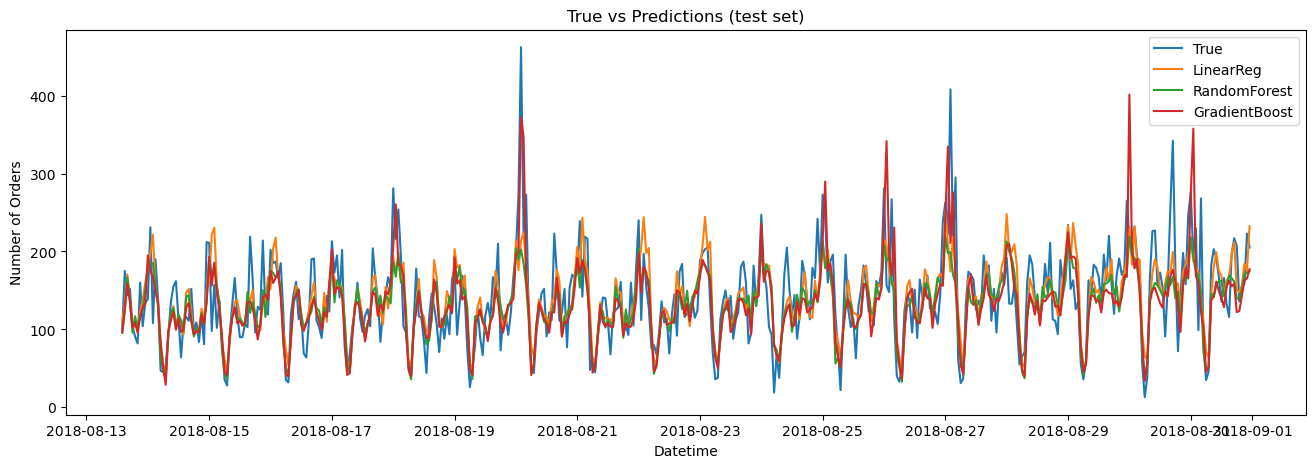

In [ ]:
# Grafica de resultados
plt.figure(figsize=(16, 5))
plt.plot(target_test.index, target_test.values, label='True')
plt.plot(target_test.index, pred_lr, label='LinearReg')
plt.plot(target_test.index, pred_rf, label='RandomForest')
plt.plot(target_test.index, pred_gb, label='GradientBoost')
plt.legend()
plt.title('True vs Predictions (test set)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()

## Conclusiones

- Todos los modelos tienen un RMSE ≤ 48 en el conjunto de prueba.
- Random Forest obtuvo el menor error (40.509), por lo que es el modelo más preciso en este caso.
- Sin embargo, la diferencia entre modelos no es muy grande, y es importante recordar que en datasets grandes el tiempo computacional aumenta significativamente entre modelos.
- Gradient Boosting quedó detrás, lo que puede deberse a que la búsqueda de hiperparámetros fue limitada.